# Chapter 3: Variational Autoencoders

## Building a Variational Autoencoder

A _variational autoencoder_ (VAE) is an autoencoder that encodes inputs into a _normal distribution_ that can be used to sample the latent space. The normal distribution in one dimension is given by

$$ f \left( x \,|\, \mu, \sigma \right) = \frac{1}{\sqrt{2\pi\sigma^2}} \, \exp \left( - \frac{(x - \mu)^2}{2\sigma^2} \right) $$

Its parameters are the _mean_, $\mu$, and the standard deviation, $\sigma$. The _standard normal distribution_ has a mean of zero and a standard deviation of one. The multidimensional normal distribution is given by

$$ f \left( \mathbf{x} \,|\, \mu,\sigma \right) =  \frac{\exp\left( -\frac{1}{2} (\mathbf{x} - \mu)^T \Sigma^{-1} (\mathbf{x} - \mu) \right)}{\sqrt{(2\pi)^k|\Sigma|}} $$

where $k$ is the number of dimensions, $\mu$ is the mean vector, and $\Sigma$ is the _covariance matrix_, which is given by

$$ \Sigma_{ij} = \left\{ \begin{matrix} \sigma_i^2 && \text{if}\;i = j \\ \rho_{ij} \sigma_i\sigma_j && \text{otherwise} \end{matrix} \right. $$

where $\rho_{ij}$ is the correlation between the two dimensions. Variational autoencoders assume that $\rho = 0$, i.e. that the dimensions in the latent space have no correlation. This means $\Sigma$ is a diagonal matrix whose values are th variance in each dimension. When training a VAE, we use the logarithm of the variance since that can fall anywhere on the interval $(-\infty,\infty)$.

### Loss Function

In addition to using MSE for the reconstruction loss, we also introduce the _Kullback Leibler (KL) divergence_, a way to measure how different a probability distribution is from another. In general it is given by

$$ \begin{align} D_{KL}\left(P\,||\,Q\right) & = -\sum\limits_{x\in X} p(x)\log q(x) + \sum\limits_{x\in X} p(x)\log p(x) \\ & = H(P,Q) - H(P) \end{align} $$

where $H(P,Q)$ is the _cross-entropy_ between $P$ and $Q$, and $H(P)$ is the entropy of P. In our case, we are measuring the KL divergence between the model and the standard normal distribution. In this special case, the KL divergence has the closed form

$$ D_{KL}\left[N(\mu,\sigma)\,||\,N(0,1)\right] = \frac{1}{2}\sum\left(1+\log\left(\sigma^2\right)-\mu^2-\sigma^2\right) $$

## Using a VAE to Reconstruct Digits

Below is an example implementation of a VAE, we will use this to reconstruct handwritten digits from the MNIST dataset. Later on, we will use it to reconstruct faces from the CelebA dataset.

In [0]:
!pip install -U tensorflow-gpu

In [0]:
# Mount Google drive to save the weights after training.
from google.colab import drive

drive.mount('/content/gdrive/')

In [0]:
# Setup, this cell should be run every time.

from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                     LeakyReLU, Dropout, Flatten, Dense,
                                     Lambda, Reshape, Conv2DTranspose,
                                     Activation)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def sampling(args):
  """Sample an encoding from the learned distribution."""
  mu, log_var = args
  return mu + K.exp(log_var / 2) * K.random_normal(shape=K.shape(mu))


def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
  """Create a LearningRateScheduler callback to decay the learning rate during training."""
  def schedule(epoch):
    return initial_lr * (decay_factor ** np.floor(epoch/step_size))
  return LearningRateScheduler(schedule)


class VariationalAutoencoder():
  """Implements a Varational Autoencoder."""

  def __init__(self, input_shape, encoder_conv_filters,
               encoder_conv_kernel_size, encoder_conv_strides,
               decoder_conv_filters, decoder_conv_kernel_size,
               decoder_conv_strides, z_dim, use_batch_normalization=False,
               use_dropout=False, dropout_rate=0.25):
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input
    for i in range(len(encoder_conv_kernel_size)):
      x = Conv2D(filters=encoder_conv_filters[i],
                 kernel_size=encoder_conv_kernel_size[i],
                 strides=encoder_conv_strides[i], padding='same',
                 name='encoder_conv_{}'.format(i + 1))(x)
      if use_batch_normalization:
        x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      if use_dropout:
        x = Dropout(rate=dropout_rate)(x)
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(z_dim, name='mu')(x)
    self.log_var = Dense(z_dim, name='log_var')(x)
    self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))
    encoder_output = Lambda(sampling,
                            name='encoder_output')([self.mu, self.log_var])
    self.encoder = Model(encoder_input, encoder_output)

    decoder_input = Input(shape=(z_dim,), name='decoder_input')
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    for i in range(len(decoder_conv_kernel_size)):
      x = Conv2DTranspose(filters=decoder_conv_filters[i],
                          kernel_size=decoder_conv_kernel_size[i],
                          strides=decoder_conv_strides[i], padding='same',
                          name='decoder_conv_t_{}'.format(i + 1))(x)
      if i < len(decoder_conv_kernel_size) - 1:
        if use_batch_normalization:
          x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        if use_dropout:
          x = Dropout(rate=dropout_rate)(x)
      else:
        x = Activation('sigmoid')(x)
    decoder_output = x
    self.decoder = Model(decoder_input, decoder_output)
    self.model = Model(encoder_input, self.decoder(encoder_output))
    self.compiled = False
    self.learning_rate = None

  def compile(self, learning_rate, r_loss_factor):
    """Compile the model."""
    self.learning_rate = learning_rate
    if self.compiled:
      return
    opt = Adam(lr=learning_rate)

    def mse(y_act, y_pred):
      return r_loss_factor * K.mean(K.square(y_act - y_pred), axis=(1, 2, 3))

    def kl_divergence(y_act, y_pred):
      return -0.5 * K.sum(
        1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)

    def loss(y_act, y_pred):
      return mse(y_act, y_pred) + kl_divergence(y_act, y_pred)
    
    self.model.compile(opt, loss=loss, metrics=[mse, kl_divergence],
                       experimental_run_tf_function=False)
    self.compiled = True

  def fit(self, X, y, batch_size, epochs, checkpoint_path=None, lr_decay=1):
    """Train the model."""
    if not self.compiled:
      raise Exception('Model not compiled')
    lr_sched = step_decay_schedule(initial_lr=self.learning_rate,
                                   decay_factor=lr_decay, step_size=1)
    callbacks = [lr_sched]
    if checkpoint_path:
      callbacks.append(ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                                       save_weights_only=True))
    self.model.fit(X, y, batch_size=batch_size, epochs=epochs, shuffle=True,
                   callbacks=callbacks)

  def load(self, checkpoint_path):
    """Load the model weights from the saved checkpoint file."""
    self.model.load_weights(checkpoint_path)

In [9]:
mnist_vae = VariationalAutoencoder(input_shape=(28, 28, 1),
                                   encoder_conv_filters=(32, 64, 64, 64),
                                   encoder_conv_kernel_size=(3, 3, 3, 3),
                                   encoder_conv_strides=(1, 2, 2, 1),
                                   decoder_conv_filters=(64, 64, 32, 1),
                                   decoder_conv_kernel_size=(3, 3, 3, 3),
                                   decoder_conv_strides=(1, 2, 2, 1),
                                   z_dim=2)
mnist_vae.model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

In [0]:
# Load the MNIST dataset.

from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
# Reshape these to be 4D tensors and scale the pixel values to [0, 1].

X_train = X_train.reshape(X_train.shape + (1,)) / 255.0
X_test = X_test.reshape(X_test.shape + (1,)) / 255.0

In [0]:
# The path to save the model weights to in Drive.

checkpoint_path = '/content/gdrive/My Drive/gdl_models/mnist_vae.hdf5'
mnist_vae.compile(learning_rate=0.0005, r_loss_factor=1000)

Now we will train the model for 200 training epochs.

In [0]:
# I removed the logs of training to reduce visual noise.

mnist_vae.fit(X_train, X_train, batch_size=32, epochs=200,
              checkpoint_path=checkpoint_path)

## Analyzing the Results

In [0]:
# Load the model.

mnist_vae.load(checkpoint_path)

In [13]:
# Evaluating the loss on the test set.

mnist_vae.model.evaluate(X_test, X_test)

10000/10000 [==============================] - 1s 133us/sample - loss: 44.5464 - mse: 39.1627 - kl_divergence: 5.3837


[44.54635668945313, 39.16269, 5.3836737]

### Reconstructing Digits

Below we compare the original images on the first row with the model's reconstruction of the respective image on the second row.

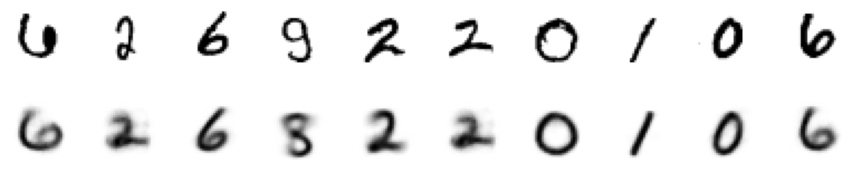

In [19]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(X_test)), n_to_show)

X_pred = mnist_vae.model.predict(X_test[example_idx])

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, x in enumerate(X_test[example_idx]):
  ax = fig.add_subplot(2, n_to_show, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), cmap='gray_r')

for i, x in enumerate(X_pred):
  ax = fig.add_subplot(2, n_to_show, n_to_show + i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), cmap='gray_r')

### Plotting the Data in the Latent Space

Below we encode the first 5,0000 images in the test set into the 2D latent space in a scatter plot. The points are labeled according to their actual label. We can see how the latent space representation has changed due to the new constraints on the model.

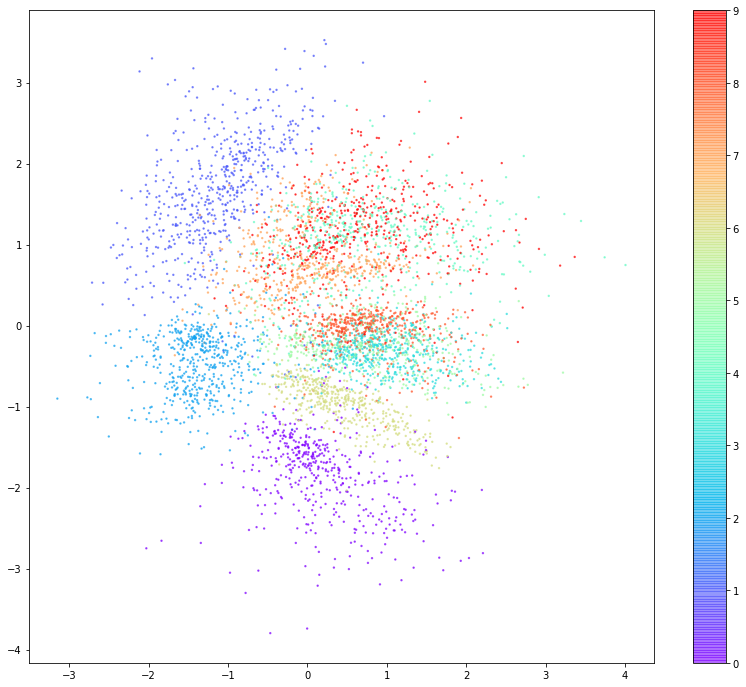

In [15]:
X_enc = mnist_vae.encoder.predict(X_test[:5000])
plt.figure(figsize=(14, 12))
plt.scatter(X_enc[:,0], X_enc[:,1], cmap='rainbow', s=2, alpha=0.6,
            c=y_test[:5000])
plt.colorbar()

### Generating New Images

Below is an example of generating new images using random points in the latent space sampled from a standard normal distribution. Despite sampling from the latent space randomly, we see that the images are mostly recognizable digits.

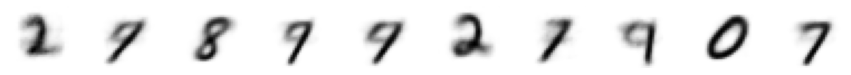

In [21]:
from numpy.random import normal
import math

n_to_show = 10

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
  ax = fig.add_subplot(1, n_to_show, i + 1)
  ax.axis('off')
  img = mnist_vae.decoder.predict(
      normal(loc=0.0, scale=1.0, size=(1, 2))).squeeze()
  ax.imshow(img, cmap='gray_r')